<center><img src="images/header.png"></center>

<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>SVM, Kernel Trick (практика)</center></h2>

**Срок сдачи:** 24 апреля 2017, 06:00 <br> 
**Штраф за опоздание:** -2 балла после 06:00 24 апреля, -4 балла после 06:00 1 мая, -6 баллов после 06:00 8 мая

При отправлении ДЗ указывайте фамилию в названии файла<br>

Не забудте создать задание в Slack через /todo.

Используйте данный Ipython Notebook при оформлении домашнего задания.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from Levenshtein import distance
from functools import partial

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 6)

# Семинарская часть

Функция `select_model` принимает на вход обучающую выборку и возвращает модель (машину опорных векторов) с наилучшими параметрами для данной выборки. Эту функцию нужно реализовать.

Подбираемые параметры подели включают в себя:
- различные функции ядра (линейное, RBF, полиномиальные разных степеней)
- различные значения константы $C$ ($0, 0.1, 1, 10, 100, 1000, 10000$)

Подбирать параметры необходимо с помощью 10-fold кросс-валидации. Сейчас в качестве заглушки функция всегда возвращает линейный SVC.

In [ ]:
def select_model(x, y):
    """
    Implement some model selection strategy here:
    seek through different kernels and parameters.

    Use a validation scheme to select the best model
    
    Quality metric: accuracy

    Returns:
        SVM classifier implemented by sklearn SVC class.
    """
    best_accuracy = 0
    best_model = None
    
    kernel = 'linear'

    model = SVC(kernel=kernel)
    print "Trying model {}".format(model)
    
    accuracy = np.mean(cross_val_score(model, x, y))

    best_model = model
    best_accuracy = accuracy
    
    best_model.fit(x, y)
    print "Best model %s, with accuracy %f" % (best_model, best_accuracy)
    return best_model

Далее две вспомогательные функции, которые отображают данные и разделяющую поверхность

In [ ]:
def plot_data_set(x, y, description=''):
    print "Plotting data set points"
    plt.figure(figsize=(8, 8))

    colors = np.array(['r', 'b'])[y]
    plt.title(description, fontsize='small')
    plt.scatter(x[:, 0], x[:, 1], marker='o', c=colors, s=50)
    
def plot_decision_region(x1_min, x2_min, x1_max, x2_max, clf, n_points=1000):
    print "Plotting decision region"
    x1, x2 = np.meshgrid(np.linspace(x1_min, x1_max, n_points), np.linspace(x2_min, x2_max, n_points))
    z = clf.decision_function(np.c_[x1.ravel(), x2.ravel()]).reshape(x1.shape)

    plt.contour(x1, x2, z, levels=[0.0], linestyles='solid', linewidths=2.0)
    plt.contour(x1, x2, z, levels=[-1.0, 1.0], linestyles='dashed', linewidths=1.0)

In [ ]:
def generate_linear(size=100, k=1.1, b=0.0, nl=0.1):
    print "Generating 'Linearly-separated' data set"

    x = np.random.random((size, 2))
    y = np.zeros(size, dtype=int)
    noise = np.random.randn(size) * nl
    y[x[:, 1] - (k * x[:, 0] + b) > noise] = 1

    return x, y

x, y = generate_linear()
clf = select_model(x, y)
plot_data_set(x, y)
plot_decision_region(x[:, 0].min(), x[:, 1].min(), x[:, 0].max(), x[:, 1].max(), clf)

In [ ]:
def generate_concentric(size=100, r1=1.0, r2=2.0, sigma=0.3):
    print "Generating 'Concentric circles' data set"
    x = np.zeros((size, 2))
    x[:size/2, 0] = sigma * np.random.randn(size/2) + r1
    x[size/2:, 0] = sigma * np.random.randn(size/2) + r2
    x[:, 1] = (np.random.random(size) - 0.5) * 2 * np.pi
    y = np.hstack([np.zeros(size/2, dtype=int), np.ones(size/2, dtype=int)])

    z = np.zeros((size, 2))
    z[:, 0] = x[:, 0] * np.cos(x[:, 1])
    z[:, 1] = x[:, 0] * np.sin(x[:, 1])

    return z, y

x, y = generate_concentric()
clf = select_model(x, y)
plot_data_set(x, y)
plot_decision_region(x[:, 0].min(), x[:, 1].min(), x[:, 0].max(), x[:, 1].max(), clf)

In [ ]:
def generate_sin(size=200):
    print "Generating 'Sinus-separated' data set"

    x = np.random.random((size, 2))
    x[:, 0] = x[:, 0] * 4 * np.pi
    x[:, 1] = (x[:, 1] - 0.5) * 2
    y = np.zeros(size, dtype=int)
    y[x[:, 1] > np.sin(x[:, 0])] = 1

    return x, y

x, y = generate_sin()
clf = select_model(x, y)
plot_data_set(x, y)
plot_decision_region(x[:, 0].min(), x[:, 1].min(), x[:, 0].max(), x[:, 1].max(), clf)

# Регрессия с SVM (3 балла)

Загрузите набор данных из *titanium.csv*<br/>
Мы будем решать задачу восстановления столбца 'y' по столбцу 'x'.

## Визуализация данных (1 балл)

Выполните стандартную предобработку данных (z-score) и выведите их на графике.

In [2]:
data = pd.read_csv('titanium.csv').values
x = data[:, 0]
y = data[:, 1]

In [3]:
from scipy.stats import zscore

In [4]:
x = zscore(x)
x = x.reshape((-1,1))
y = zscore(y)

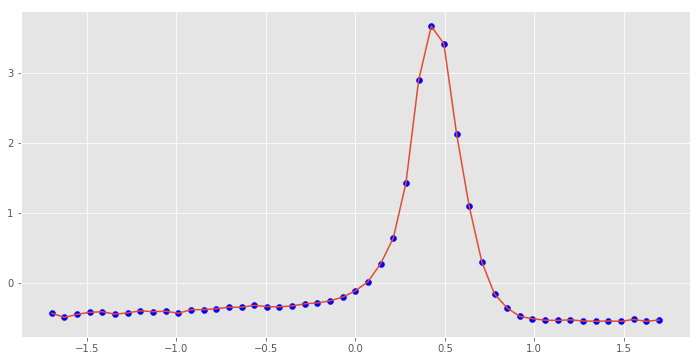

In [5]:
plt.scatter(x, y, color='b')
plt.plot(x,y)

## Обучение моделей (2 балла)

Рассмотрите 3 ядра: 
* Линейное
* Полиномиальное (degree = 3, gamma = 6, coef0 = 1)
* RBF (gamma = 6, coef0 = 1)

Во всех случаях установить ширину трубки `epsilon=0.01`

Для каждого из ядер:
1. Пусть `C = np.logspace(-2, 2, 10)`. Постройте графики зависимости ошибки от параметра $C$ (ось графика со значениями параметра $C$ должна быть в логарифмической шкале). Ошибка измеряется как средняя абсолютная ошибка. 
2. Для наулучшего параметра $С$ каждого из ядер постройте график с данными и предстазанием по svm

В каких случаях возникает эффекты недообучения, переобучения?

In [6]:
from sklearn.metrics import mean_absolute_error

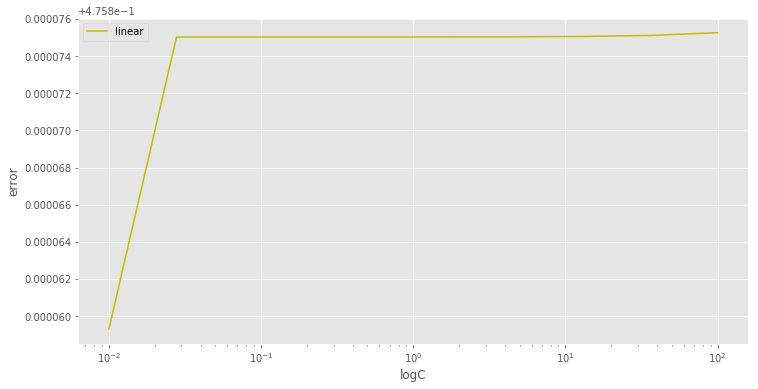

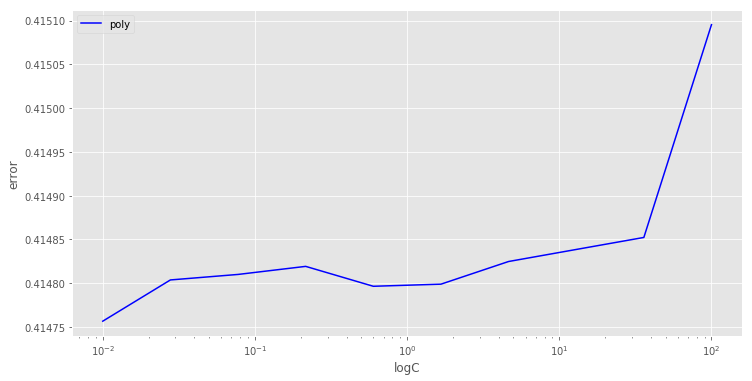

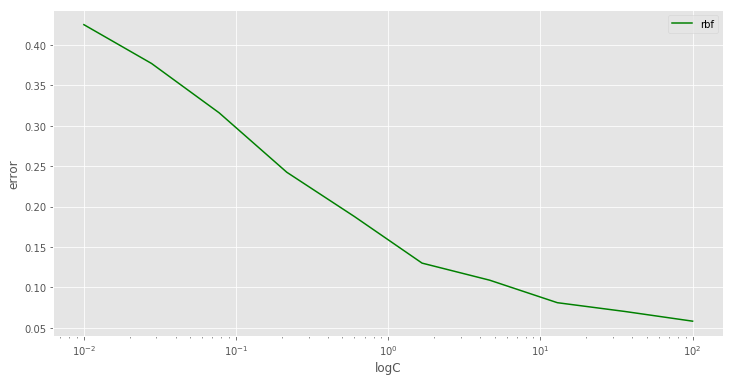

In [8]:
C = np.logspace(-2, 2, 10)
kernels = ['linear','poly','rbf']
colors = 'ybg'
best_C = {}
error_list = []
min_error = 10
for kernel, color in zip(kernels,colors):
    for c in C:
        model = SVR(kernel=kernel, C=c, degree=3, gamma=6, coef0=1, epsilon=0.01).fit(x,y)
        y_pred = model.predict(x)
        temp_error = mean_absolute_error(y_true=y, y_pred=y_pred)
        error_list.append(temp_error)
        if temp_error < min_error:
            best_C[kernel] = c
            min_error = temp_error
    plt.subplots()
    plt.plot(C,error_list, color=color, label=str(kernel))
    plt.xscale('log')
    plt.xlabel(u'logC')
    plt.ylabel(u'error')
    error_list=[]
    min_error=10
    plt.legend()

## rbf - переобучение, linear и poly - серьёзное недообучение.

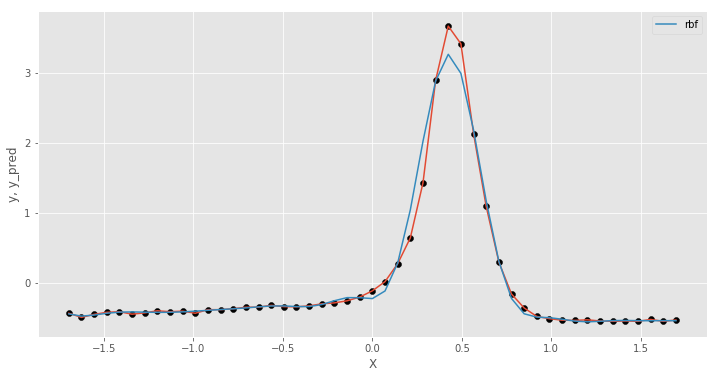

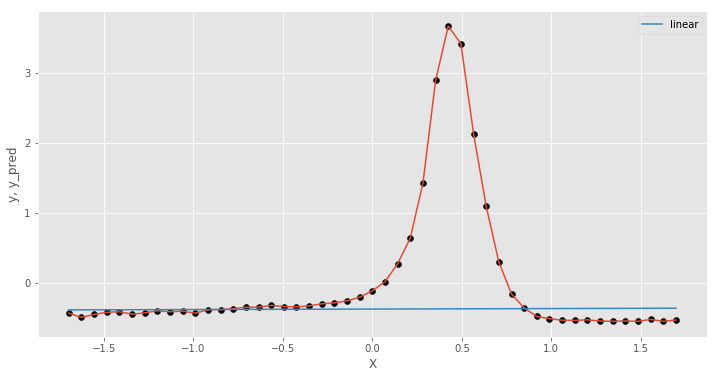

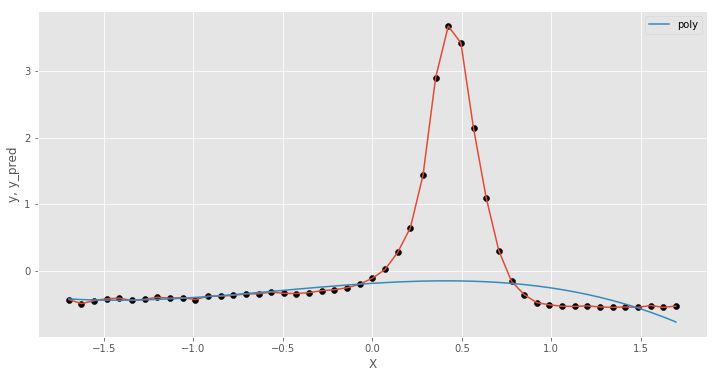

In [9]:
for key, value in best_C.iteritems():
    model=SVR(kernel=key, C=value, degree=3, gamma=6, coef0=1, epsilon=0.01).fit(x,y)
    y_pred=model.predict(x)
    plt.subplots()
    plt.scatter(x, y, color='black')
    plt.plot(x,y)
    plt.plot(x,y_pred,label=str(key))
    plt.xlabel(u'X')
    plt.ylabel(u'y, y_pred')
    plt.legend()

# Определение языка слова (7 баллов)

В данном задании вам необходимо определить, на каком языке написано слово.

Вам будет дано два текста - первые предложения произведения "Война и Мир" на английком и испанском, разбитые на слова. У слов нет общепринятого числового представления, поэтому мы предлагаем вам реализовать собственноге ядро для SVM, основанное на редакторском расстоянии или [расстоянии Левинштейна](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%9B%D0%B5%D0%B2%D0%B5%D0%BD%D1%88%D1%82%D0%B5%D0%B9%D0%BD%D0%B0). 

Имплементировать расстояние Леванштейна не нужно - можно взять любую доступную реализацию, например [здесь](https://github.com/toastdriven/pylev) или [здесь](https://github.com/ztane/python-Levenshtein).

## Загрузка (1 балл)

Загрузите данные из файлов *war_and_peace_es.txt* и *war_and_peace_en.txt*.<br/> 
В результате вы должны получить pandas.DataFrame со столбцами *index* | *word* | *label*, где *index* - это индекс pandas, *word* - это слово и *label* - это метка класса (0 или 1)

In [10]:
df_es = pd.read_csv('war_and_peace_es.txt', names=['word'])
df_es['label'] = 0
df_en = pd.read_csv('war_and_peace_en.txt', names=['word'])
df_en['label'] = 1
df = pd.concat([df_es, df_en], ignore_index=True)

In [11]:
# like this
print df.shape
df.head()

(11403, 2)


,word,label
0,guerra,0
1,pace,0
2,lev,0
3,nicoevic,0
4,tolstj,0


## Подготовка данных (2 балла)

Особенностью пользовательского ядра в sklean.SVC является то, что на вход оно должно принимать именно вектора чисел.<br/>
В нашем случае это будут индексы соответствующих слов из корпуса. То есть вместо вектора ['treat', 'celebrit', 'prince', ...] на вход в ядро подается вектор из индексов [9209, 11145, 7735, ...] с помощью которых вы будете находить сами слова.

Прежде чем мы начнем строить ядро, надо подготовить данные. Для этого:
1. Задайте переменную RND_SEED, которая будет использоваться в любых генераторах случайных чисел в вашем коде (обычно параметр "random_seed")
2. Случайным образом перемешайте и заново проиндексируйте таблицу, полученную выше (используйте методы df.sample() и df.reset_index())
3. Ядро может вычисляться достаточно долго, поэтому можете урезать таблицу, но оставить в ней не менее 1000 слов.
4. Разбейте данные на обучающую и контрольную выборку в пропорции 60/40

В результате вы должны получить вектор-столбец X_train, X_test с **индексами** слов и векторы y_train, y_test с метками классов.

In [13]:
from sklearn.cross_validation import train_test_split

In [14]:
RND_SEED = 69

In [15]:
df = df.sample(n=df.shape[0],random_state=RND_SEED)
df = df.reset_index(drop=True)
df.head()

,word,label
0,evacuare,0
1,par,0
2,sapevate,0
3,social,1
4,gave,1


In [16]:
df1k = df.iloc[:1000,:]
x, y = np.array(df1k.index), np.array(df1k.iloc[:,1])

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.40, random_state=RND_SEED)

In [18]:
diction = df.to_dict(orient='dict')['word']

In [19]:
diction

{0: 'evacuare',
 1: 'par',
 2: 'sapevate',
 3: 'social',
 4: 'gave',
 5: 'habitual',
 6: 'bene',
 7: 'sangue',
 8: 'movement',
 9: 'che',
 10: 'nel',
 11: 'osserv',
 12: 'qualcosa',
 13: 'antichrist',
 14: 'only',
 15: 'forgotten',
 16: 'beginning',
 17: 'senza',
 18: 'about',
 19: 'man',
 20: 'promise',
 21: 'osserv',
 22: 'chi',
 23: 'the',
 24: 'louis',
 25: 'the',
 26: 'everything',
 27: 'guerre',
 28: 'donna',
 29: 'dellaustria',
 30: 'hurriedly',
 31: 'capo',
 32: 'his',
 33: 'returned',
 34: 'atrocits',
 35: 'anatolij',
 36: 'condizione',
 37: 'esclam',
 38: 'non',
 39: 'era',
 40: 'arranged',
 41: 'era',
 42: 'baron',
 43: 'company',
 44: 'began',
 45: 'wonderful',
 46: 'train',
 47: 'per',
 48: 'mine',
 49: 'anna',
 50: 'affrett',
 51: 'viste',
 52: 'you',
 53: 'plus',
 54: 'per',
 55: 'dopo',
 56: 'mano',
 57: 'mentre',
 58: 'vocation',
 59: 'alla',
 60: 'very',
 61: 'own',
 62: 'now',
 63: 'principessa',
 64: 'una',
 65: 'called',
 66: 'sake',
 67: 'steadily',
 68: 'moglie',

## Расчет ядра (3 балла)

Некоторые указания по составлению пользовательского ядра можно найти [здесь](http://stackoverflow.com/questions/26962159/how-to-use-a-custom-svm-kernel).

Если в двух словах:<br/>
Функция, реазлизующая расчет ядра должна принимать две матрицы $U$ и $V$ с признаковым описанием объектов (во време обучения они обе относятся к обучающей выборке, а во время применения - одна матрица относится к обучающей выборке, а другая к контрольной).

В результате, функция должна возвращать матрицу ядра $G_{ij} = K(U_i, V_j)$.

Таким образом, в этом задании вам надо:
1. Написать функцию *string_kernel(U, V)*, расчитывающее матрицу ядра $G_{ij}$
2. Визуализировать матрицу только для обучающей выборки (функция plt.imshow()).

**ВАЖНО**<br/>
На лекции мы рассмотрели, что ядро должно обладать определенными свойствами, поэтому не получится рассчитать $G_{ij}$ как расстояние Левинштейна между словами $\text{word}_i$ и $\text{word}_j$.<br/>
Вместо этого используйте какое-нибудь готовое ядро, зависящее от расстояние между объектами.

In [38]:
def rbf(metric, x1, x2, gamma, degree):
    return np.exp(-gamma * np.power(metric(x1, x2), degree))

def rbf_kernel_leven(x1, x2, gamma):
    return rbf(distance, x1, x2, gamma, 2)

def string_kernel_proxy(U, V, kernel, gamma, dictionary):
    G = np.empty((U.shape[0], V.shape[0]), dtype=np.float64)
    for i, x in enumerate(U):
        for j, y in enumerate(V):
            G[i, j] = kernel(dictionary[x[0]], dictionary[y[0]], gamma)
    return G

string_kernel = partial(string_kernel_proxy, kernel=rbf_kernel_leven, gamma=0.1, dictionary=diction)

G = string_kernel(x_train, x_train)

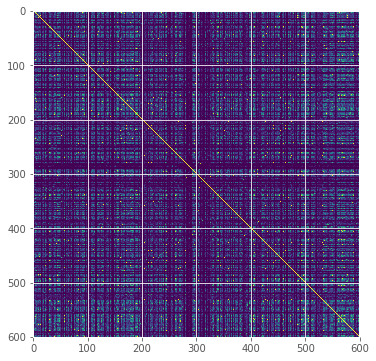

In [23]:
plt.imshow(G)

## Оценка качества (1 балл)

Обучите метод опорных векторов с различными значениями параметра штрафа $C$.<br/>
Для каждого значения выведите accuracy на обучащюей и контрольной выборке.

Постарайтесь достичь качества в 70% на тестовой выборке

In [24]:
from sklearn.metrics import accuracy_score

In [36]:
x_train = x_train.reshape(-1,1)
x_test = x_test.reshape(-1,1)
x_train.shape

(600, 1)

In [39]:
for gamma in np.logspace(-2, 2, 5):
    string_kernel = partial(string_kernel_proxy, kernel=rbf_kernel_leven, gamma=gamma, dictionary=diction)
    for C in np.logspace(-2, 2, 5):
        svc = SVC(C=C, kernel=string_kernel, random_state=RND_SEED).fit(x_train, y_train)
        test_accuracy = accuracy_score(y_test, svc.predict(x_test))
        print "gamma:, ", gamma, ", C:", C
        print "Accuracy on test data: ", test_accuracy

gamma:,  0.01 , C: 0.01
Accuracy on test data:  0.5275
gamma:,  0.01 , C: 0.1
Accuracy on test data:  0.6775
gamma:,  0.01 , C: 1.0
Accuracy on test data:  0.6525
gamma:,  0.01 , C: 10.0
Accuracy on test data:  0.6
gamma:,  0.01 , C: 100.0
Accuracy on test data:  0.615
gamma:,  0.1 , C: 0.01
Accuracy on test data:  0.5275
gamma:,  0.1 , C: 0.1
Accuracy on test data:  0.6775
gamma:,  0.1 , C: 1.0
Accuracy on test data:  0.805
gamma:,  0.1 , C: 10.0
Accuracy on test data:  0.7425
gamma:,  0.1 , C: 100.0
Accuracy on test data:  0.7275
gamma:,  1.0 , C: 0.01
Accuracy on test data:  0.5275
gamma:,  1.0 , C: 0.1
Accuracy on test data:  0.59
gamma:,  1.0 , C: 1.0
Accuracy on test data:  0.7475
gamma:,  1.0 , C: 10.0
Accuracy on test data:  0.75
gamma:,  1.0 , C: 100.0
Accuracy on test data:  0.75
gamma:,  10.0 , C: 0.01
Accuracy on test data:  0.5275
gamma:,  10.0 , C: 0.1
Accuracy on test data:  0.5875
gamma:,  10.0 , C: 1.0
Accuracy on test data:  0.7325
gamma:,  10.0 , C: 10.0
Accuracy on 

## Наилучшие параметры: гамма=0.1, С=1. Качество=0.8